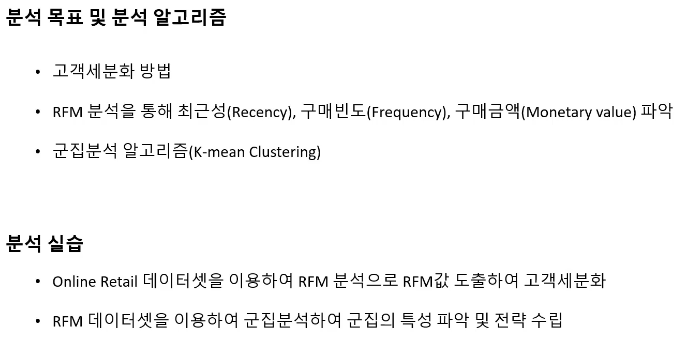

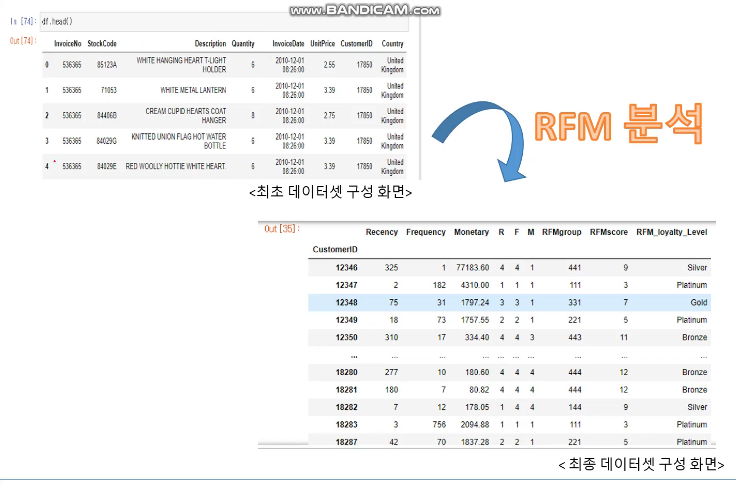

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

In [2]:
df = pd.read_csv('data/OnlineRetail_new.csv')
df.head()

,InvoiceNo,InvoiceDate,Code,Description,Quantity,Unit,Total,CustomerID,Country
0,536365,2010-12-01 08:26:00,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,15.30,17850,United Kingdom
1,536365,2010-12-01 08:26:00,71053,WHITE METAL LANTERN,6,3.39,20.34,17850,United Kingdom
2,536365,2010-12-01 08:26:00,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,22.00,17850,United Kingdom
3,536365,2010-12-01 08:26:00,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,20.34,17850,United Kingdom
4,536365,2010-12-01 08:26:00,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,20.34,17850,United Kingdom


In [3]:
# 데이터 형변환
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
df['InvoiceDate'] = df['InvoiceDate'].astype('datetime64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397924 entries, 0 to 397923
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   InvoiceDate  397924 non-null  datetime64[ns]
 2   Code         397924 non-null  object        
 3   Description  397924 non-null  object        
 4   Quantity     397924 non-null  int64         
 5   Unit         397924 non-null  float64       
 6   Total        397924 non-null  float64       
 7   CustomerID   397924 non-null  int64         
 8   Country      397924 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 27.3+ MB


In [4]:
df['InvoiceDate'].sort_values()

0        2010-12-01 08:26:00
1        2010-12-01 08:26:00
2        2010-12-01 08:26:00
3        2010-12-01 08:26:00
4        2010-12-01 08:26:00
                 ...        
397911   2011-12-09 12:50:00
397910   2011-12-09 12:50:00
397909   2011-12-09 12:50:00
397915   2011-12-09 12:50:00
397923   2011-12-09 12:50:00
Name: InvoiceDate, Length: 397924, dtype: datetime64[ns]

In [5]:
latest_date = dt.datetime(2011, 12, 11)
latest_date

datetime.datetime(2011, 12, 11, 0, 0)

In [6]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate' : lambda x : (latest_date - x.max()).days,
    'InvoiceNo' : lambda x : x.count(),
    'Total' : lambda x : x.sum()
})

rfm.head()

,InvoiceDate,InvoiceNo,Total
CustomerID,,,
12346,326,1,77183.60
12347,3,182,4310.00
12348,76,31,1797.24
12349,19,73,1757.55
12350,311,17,334.40


agg 메서드는 다중집계작업을 간결하게 나타낼 수 있도록 한다.
- InvoiceDate에서는 최근성(Recency)을 확인하기 위해 기준일(latest_date)에서 최근 주문일(InvoiceDate.max)을 빼고,  그 값을 일(day) 기준으로 나타낸다.
- InvoiceNo에서는 주문 횟수(Frequency)를 계산하기 위해 count를 사용한다
- Total에서는 주문 금액(Monetary)을 계산하기 위해 sum을 사용한다.

In [7]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4339 entries, 12346 to 18287
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceDate  4339 non-null   int64  
 1   InvoiceNo    4339 non-null   int64  
 2   Total        4339 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 135.6 KB


In [8]:
rfm.rename(columns={
    'InvoiceDate' : 'Recency',
    'InvoiceNo' : 'Frequency',
    'Total' : 'Monetary'}, inplace = True)
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,3,182,4310.00
12348,76,31,1797.24
12349,19,73,1757.55
12350,311,17,334.40


In [9]:
quans = rfm.quantile(q=[.25, .5, .75])
quans

,Recency,Frequency,Monetary
0.25,18.0,17.0,307.245
0.50,51.0,41.0,674.450
0.75,142.5,100.0,1661.640


In [10]:
def R_scoring(x):
    if x <= quans['Recency'][.25]:
        return 1
    if x <= quans['Recency'][.5]:
        return 2
    if x <= quans['Recency'][.75]:
        return 3
    else :
        return 4
    
    
def FM_scoring(y, c):
    if y <= quans[c][.25]:
        return 4
    if y <= quans[c][.5]:
        return 3
    if y <= quans[c][.75]:
        return 2
    else:
        return 1

In [11]:
rfm['R'] = rfm['Recency'].apply(lambda x : R_scoring(x))
rfm['F'] = rfm['Frequency'].apply(lambda x : FM_scoring(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x : FM_scoring(x, 'Monetary'))
rfm.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12346,326,1,77183.60,4,4,1
12347,3,182,4310.00,1,1,1
12348,76,31,1797.24,3,3,1
12349,19,73,1757.55,2,2,1
12350,311,17,334.40,4,4,3


In [12]:
rfm['RFM_Group'] = rfm['R'].map(str)+rfm['F'].map(str)+rfm['M'].map(str)
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis=1)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Group,RFM_Score
CustomerID,,,,,,,,
12346,326,1,77183.60,4,4,1,441,9
12347,3,182,4310.00,1,1,1,111,3
12348,76,31,1797.24,3,3,1,331,7
12349,19,73,1757.55,2,2,1,221,5
12350,311,17,334.40,4,4,3,443,11


In [13]:
level = ['Platinum', 'Gold', 'Silver', 'Bronze']

rfm['RFM_Loyalty_Level'] = pd.qcut(x=rfm['RFM_Score'], q=4, labels=level)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Group,RFM_Score,RFM_Loyalty_Level
CustomerID,,,,,,,,,
12346,326,1,77183.60,4,4,1,441,9,Silver
12347,3,182,4310.00,1,1,1,111,3,Platinum
12348,76,31,1797.24,3,3,1,331,7,Gold
12349,19,73,1757.55,2,2,1,221,5,Platinum
12350,311,17,334.40,4,4,3,443,11,Bronze


- qcut 함수를 이용하면 구간의 개수를 동일하게 나눌 수 있다.

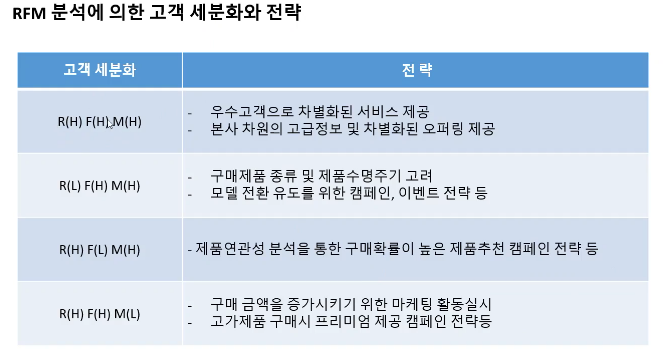

In [14]:
rfm.to_csv('data/rfm.csv')